In [1]:
import re
import math
import time
import warnings
import numpy as np
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## for preprocessing
from sklearn.preprocessing import StandardScaler

## for classification
from sklearn.multioutput import ClassifierChain
from sklearn.ensemble import RandomForestClassifier

## for metrics
from sklearn.metrics import accuracy_score, jaccard_score, f1_score

## for bag-of-words / Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for universal sentence encoder
import tensorflow_hub as hub

## Plotting tools
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns

## dump
import joblib

C:\Users\james\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# Allow to display all dataframes columns
pd.set_option("display.max_columns", None)

# Inactivate warnings
warnings.filterwarnings('ignore')

# Chargement du jeu de données

In [3]:
data = pd.read_pickle('df_save.pkl')  

In [4]:
data.shape

(10243, 36)

In [5]:
data.columns

Index(['text', 'list_tokens', 'str_tokens', 'Dominant_Topic',
       'Perc_Contribution', 'topic_0', 'topic_1', 'topic_2', 'topic_3',
       'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9',
       'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15',
       'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21',
       'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27',
       'topic_28', 'topic_29', 'Tags_list'],
      dtype='object')

# Split

In [6]:
print('Split Dataset')
print('---------------------------------------------------------')
X_train, X_test = train_test_split(data, random_state=0, test_size=0.2)
print('X_train: ' + str(X_train.shape))
print('X_test: ' + str(X_test.shape))

Split Dataset
---------------------------------------------------------
X_train: (8194, 36)
X_test: (2049, 36)


In [7]:
y_train = X_train[['Tags_list']]
y_test = X_test[['Tags_list']]
print('y_train: ' + str(y_train.shape))
print('y_test: ' + str(y_test.shape))

y_train: (8194, 1)
y_test: (2049, 1)


# Target encoder

In [8]:
mlb = MultiLabelBinarizer()

In [9]:
y_train = mlb.fit_transform(y_train.Tags_list)

In [10]:
y_test = mlb.transform(y_test.Tags_list)

# Extraction de tags

In [11]:
def check_overfitting(model, X_train, limit):
    grid = GridSearchCV(model,
                        param_grid={},
                        scoring='f1_samples',
                        verbose=1,
                        cv=5,
                        n_jobs=-1,
                        return_train_score=True,
                        refit=True)
    grid.fit(X_train, y_train)
    train_score = grid.cv_results_['mean_train_score'][0]
    test_score = grid.cv_results_['mean_test_score'][0]
    
    print('train_score:', train_score)
    print('test_score:', test_score)
    print('')
    
    if (train_score - test_score) <= limit:
        print('model is not ovefitting')
    else:
        print('model is ovefitting')
        raise

In [12]:
eval_acc = {}
eval_jac = {}
eval_f1 = {}

def evaluation(case, y_true, y_pred, mlb):
    global eval_acc, eval_f1
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:",  round(accuracy,2))
    
    # jacard
    jacard = jaccard_score(y_true, y_pred, average='samples')
    print('Jacard:', round(jacard,2)) 
    
    # f1
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average='samples')
    print('F1:', round(f1,2)) 
    
    eval_acc[case] = accuracy    
    eval_jac[case] = jacard
    eval_f1[case] = f1

## Approche semi-supervisée

In [13]:
X_train_semi = X_train.loc[:, (X_train.columns != 'text') &
                              (X_train.columns != 'list_tokens') &
                              (X_train.columns != 'str_tokens') &
                              (X_train.columns != 'Tags_list')
                           ]
X_test_semi = X_test.loc[:, (X_test.columns != 'text') &
                            (X_test.columns != 'list_tokens') &
                            (X_test.columns != 'str_tokens') &
                            (X_test.columns != 'Tags_list')
                         ]
print('X_train_semi: ' + str(X_train_semi.shape))
print('X_test_semi: ' + str(X_test_semi.shape))

X_train_semi: (8194, 32)
X_test_semi: (2049, 32)


In [14]:
lda = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', ClassifierChain(RandomForestClassifier(n_estimators=100, max_features=32,
                                                     max_depth=10, min_samples_leaf=5,
                                                     min_samples_split=0.1, class_weight='balanced')))
])

In [15]:
check_overfitting(lda, X_train_semi, 0.1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
train_score: 0.1965442832073501
test_score: 0.17447752562607124

model is not ovefitting


In [16]:
lda.fit(X_train_semi, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 ClassifierChain(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                                       max_depth=10,
                                                                       max_features=32,
                                                                       min_samples_leaf=5,
                                                                       min_samples_split=0.1)))])

In [17]:
predicted_semi = lda.predict(X_test_semi)

In [18]:
evaluation('lda', y_test, predicted_semi, mlb)

Accuracy: 0.01
Jacard: 0.12
F1: 0.18


# Résultat final

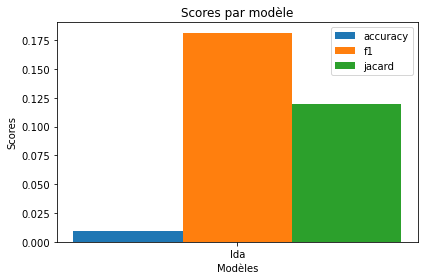

In [19]:
ind = np.arange(1) 
width = 0.25       
plt.bar(ind, eval_acc.values(), width, label='accuracy')
plt.bar(ind + width, eval_f1.values(), width, label='f1')
plt.bar(ind + (width * 2), eval_jac.values(), width, label='jacard')

plt.xlabel('Modèles')
plt.ylabel('Scores')
plt.title('Scores par modèle')

plt.xticks(ind + width, ['lda'])
plt.legend(loc='best')

plt.tight_layout()
plt.gcf().savefig('test_result', dpi=100)
plt.show()

# Calibration du modèle choisi

In [20]:
def calibration(model, X, y_true):
    # Probability calibration
    f1_tab = []
    accuracy_tab = []
    jacard_tab = []
    x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    for i in x:
        y_pred = (model.predict_proba(X) >= i).astype(bool) 
        f1 = f1_score(y_true=y_true, y_pred=y_pred, average='samples')
        f1_tab.append(f1)
        accuracy = accuracy_score(y_true, y_pred)
        accuracy_tab.append(accuracy)
        jacard = jaccard_score(y_true, y_pred, average='samples')
        jacard_tab.append(jacard)

    line1, = plt.plot(x, f1_tab, 'b', label='f1')
    line2, = plt.plot(x, accuracy_tab, 'r', label='accuracy')
    line3, = plt.plot(x, jacard_tab, 'g', label='jacard')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('score')
    plt.xlabel('probabilté')
    plt.show()

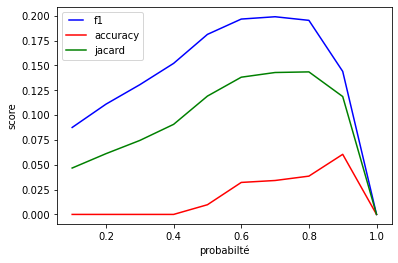

In [22]:
calibration(lda, X_test_semi, y_test)

In [26]:
y_pred_lda = (lda.predict_proba(X_test_semi) >= 0.85).astype(bool) 
y_pred_lda_rev = mlb.inverse_transform(y_pred_lda)
print(y_pred_lda_rev[0], mlb.inverse_transform(y_test)[0])

('android', 'c#', 'database', 'linq', 'objective-c', 'sql', 'sql-server', 'wpf') ('android',)
